In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath("../CONSTANTS.py")))

import copy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils.learning_path import LearningPath
from utils.cm_generator import CMGenerator
from metrics.tau import Tau
from metrics.fbs import FBS
%matplotlib inline

#### Data:
Two sets of learning paths, one from training CNN on digits 0 and 1 of MNIST, and the other from training CNN on digits 3 and 8. Each set contains 100 trials, each with 79 epochs. These paths are already computed and available at `../pickled_data`.

#### Objective:
Find the best way that statistically separates the learning path of CNN on classes 0 and 1, and 3 and 8.

In [9]:
def drop_elements(l: list, indices: list, in_place=True) -> list:
    """Drops elements of the given list using the given indices. If `in_place` is set to `False`, the given list will remain unchanged."""
    if in_place:
        tmp_list = l
    else:
        tmp_list = copy.deepcopy(l)
        
    for index in sorted(indices, reverse=True):
        del tmp_list[index]
    return tmp_list

def get_outliers(data, m=2):
    """finds and returns the indices of outliers in the given list. The outliers are those values which fall outside the interquartile range with parameter `m`."""
    ind = np.argwhere(abs(data - np.mean(data)) > m * np.std(data))
    return ind.flatten().tolist()

#### Load the pickled CMs.

In [3]:
file_01 = '../pickled_data/all_cms_[0]_rounds_[80]_iters_lr_[0.01]_[0]_[1]_classes.pkl'
file_38 = '../pickled_data/all_cms_[0]_rounds_[80]_iters_lr_[0.01]_[3]_[8]_classes.pkl'
f = open(file_01, 'rb')
all_paths_a = pickle.load(f)
f.close()
f = open(file_38, 'rb')
all_paths_b = pickle.load(f)
f.close()

#### Choose a pair of paths to plot.

In [4]:
index = 19  # <-------------------------- choose the index (0 <= index <= 99).
path_a = all_paths_a[index]
path_b = all_paths_b[index]

#### Prepare the Contingency Space for a given metric.

In [5]:
step_size = 30
n, p = 2500, 2500  # <-------------------------- choose the imbalance ratio for the CS surface to be generated.
gen = CMGenerator(n_p=p, n_n=n, n_cm=step_size)
gen.generate_cms()

all_f1s, model_tau_a, model_tau_b = [], [], []

for cm in gen.all_cms:  # <-------------------------- choose the metric you want to visualize its surface.
    f1s = FBS(cm)
    all_f1s.append(f1s.value)
    
f1s_mat = np.flip(np.array(all_f1s).reshape((step_size, step_size)), 0)

model_points_a, model_points_b = [], []
for cm_a, cm_b in zip(path_a, path_b):
    tau = Tau(cm_a)
    model_tau_a.append(tau.value)
    model_points_a.append(tau.model_point)
    
    tau = Tau(cm_b)
    model_tau_a.append(tau.value)
    model_points_b.append(tau.model_point)

#### Plot the Contingency space, the metric's surface, and the learning path of one trial.

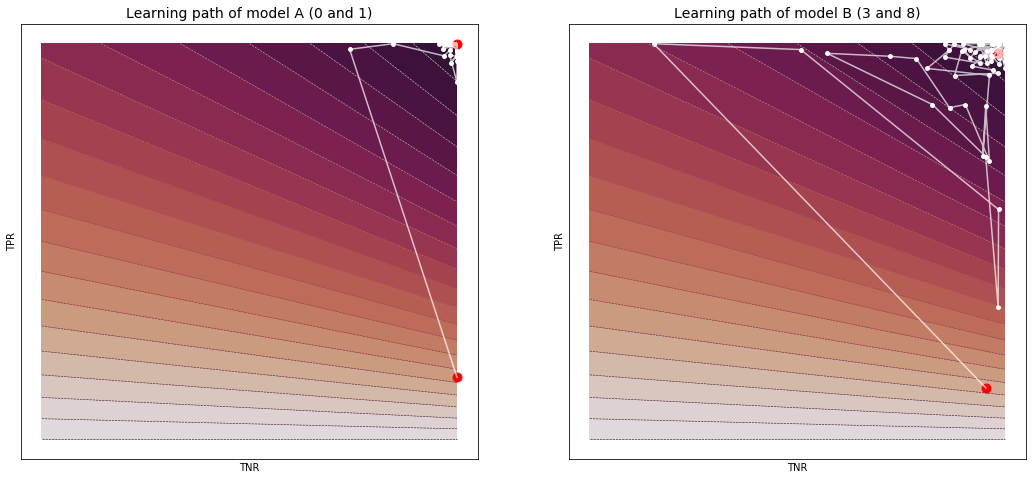

In [6]:
space_w = 10
space_h = 10
x = np.linspace(0, space_w, step_size)
y = np.linspace(0, space_h, step_size)
X, Y = np.meshgrid(x, y)
model_points_a_x = [p[0] * space_w for p in model_points_a]
model_points_a_y = [p[1] * space_h for p in model_points_a]

model_points_b_x = [p[0] * space_w for p in model_points_b]
model_points_b_y = [p[1] * space_h for p in model_points_b]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
# Plot for Model A --------------------
cp = axs[0].contourf(X, Y, np.flipud(f1s_mat), 20, cmap='twilight_shifted', vmin = -1, vmax=1)
cp2 = axs[0].contour(X, Y, np.flipud(f1s_mat), 20, cmap='twilight', vmin = -1, vmax=1, linewidths=.6, linestyles='dashed')
axs[0].plot(model_points_a_x, model_points_a_y, color='white', linewidth=1.5, linestyle="-", alpha=0.7)
axs[0].scatter(model_points_a_x, model_points_a_y, marker='o', color='white', s=15)
axs[0].scatter(model_points_a_x[0], model_points_a_y[0], marker='o', color='red', s=80)
axs[0].scatter(model_points_a_x[-1], model_points_a_y[-1], marker='o', color='red', s=80)
axs[0].set_xlim([-0.5,space_w + 0.5])
axs[0].set_ylim([-0.5,space_h + 0.5])
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title("Learning path of model A (0 and 1)", fontsize=14)
axs[0].set(xlabel='TNR', ylabel='TPR')

# Plot for Model B --------------------
cp = axs[1].contourf(X, Y, np.flipud(f1s_mat), 20, cmap='twilight_shifted', vmin = -1, vmax=1)
cp2 = axs[1].contour(X, Y, np.flipud(f1s_mat), 20, cmap='twilight', vmin = -1, vmax=1, linewidths=.6, linestyles='dashed')
axs[1].plot(model_points_b_x, model_points_b_y, color='white', linewidth=1.5, linestyle="-", alpha=0.7)
axs[1].scatter(model_points_b_x, model_points_b_y, marker='o', color='white', s=15)
axs[1].scatter(model_points_b_x[0], model_points_b_y[0], marker='o', color='red', s=80)
axs[1].scatter(model_points_b_x[-1], model_points_b_y[-1], marker='o', color='red', s=80)
axs[1].set_xlim([-0.5,space_w + 0.5])
axs[1].set_ylim([-0.5,space_h + 0.5])
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("Learning path of model B (3 and 8)", fontsize=14)
axs[1].set(xlabel='TNR', ylabel='TPR')
plt.show()

#### Let's compute all 3 methods.

In [7]:
# All lists:
all_cm_steps_a, all_cm_steps_b = [], []                 # step sizes in 2d space ---------------- list of lists
all_cs_steps_a, all_cs_steps_b = [], []                 # step sizes in 3d space ---------------- list of lists
all_net_areas_a, all_net_areas_b = [], []               # sums of signed areas ------------------ list of floats
all_cm_steps_sums_a, all_cm_steps_sums_a = [], []       # sums of paths' 2d step sizes ---------- list of floats
all_cs_steps_sums_a, all_cs_steps_sums_b = [], []       # sums of paths' 3d step sizes ---------- list of floats
all_sum_cs_sqr_a, all_sum_cs_sqr_b = [], []             # sums of paths' squared 3d step sizes -- list of floats
all_cs_steps_means_a, all_cs_steps_means_b = [], []     # means of paths' squared 3d step sizes - list of floats

for path_a, path_b in zip(all_paths_a, all_paths_b):
    # compute impact for A
    lp = LearningPath(path_a, FBS, normalize=True)
    lp.compute_impact()
    all_net_areas_a.append(lp.net_triangle_area)
    all_cs_steps_a.append(lp.cs_steps)
    all_cm_steps_a.append(lp.cm_steps)
    all_sum_cs_sqr_a.append(np.sum(np.power(lp.cs_steps, 2)))
    
    # compute impact for B
    lp = LearningPath(path_b, FBS, normalize=True)
    lp.compute_impact()
    all_net_areas_b.append(lp.net_triangle_area)
    all_cs_steps_b.append(lp.cs_steps)
    all_cm_steps_b.append(lp.cm_steps)
    all_sum_cs_sqr_b.append(np.sum(np.power(lp.cs_steps, 2)))
    
all_cs_steps_sums_a = list(np.sum(all_cs_steps_a, axis=1)) # a list of 100 values, each the sum of step sizes of 79 epochs
all_cs_steps_sums_b = list(np.sum(all_cs_steps_b, axis=1)) # a list of ...

all_cm_steps_sums_a = list(np.sum(all_cm_steps_a, axis=1)) # a list of ...
all_cm_steps_sums_b = list(np.sum(all_cm_steps_b, axis=1)) # a list of ...


all_cs_steps_means_a = np.mean(all_cs_steps_a, axis=1) # a list of 100 values, each the mean of step sizes of 79 epochs
all_cs_steps_means_b = np.mean(all_cs_steps_b, axis=1) # a list of ...

all_cm_steps_means_a = np.mean(all_cm_steps_a, axis=1) # a list of ...
all_cm_steps_means_b = np.mean(all_cm_steps_b, axis=1) # a list of ...

#### Remove Outlier Paths:
In some cases it is possible that the model is stuck at a local minimum. This is mainly because our CNN architecture is very simple. 

These outliers should be detected and removed. I used the method `get_outliers` (see the beginning of notebook) to find the suspicous ones. The dropped indices are shown below:

```
outlier paths A: 20, 32
outlier paths B: 13, 22, 58, 77, 85
```

In [10]:
out_a = get_outliers(all_cs_steps_sums_a)
out_b = get_outliers(all_cs_steps_sums_b)
print(out_a, out_b)

[1, 12, 20, 32, 33, 56] [13, 22, 58, 77, 85, 89]


#### After I visually verified which of the suspicious paths are indeed outliers, I dropped them.

In [11]:
outliers_index = [13, 20, 22, 32, 58, 77, 85]
temp_bag = [all_net_areas_a, all_cs_steps_a, all_cm_steps_a, all_sum_cs_sqr_a, all_cs_steps_sums_a, all_cm_steps_sums_a,
            all_net_areas_b, all_cs_steps_b, all_cm_steps_b, all_sum_cs_sqr_b, all_cs_steps_sums_b, all_cm_steps_sums_b]
for i, l in enumerate(temp_bag):
    drop_elements(l, outliers_index, in_place=True)

In [12]:
# Total number of path after outlier detection
for l in temp_bag:
    print(len(l))

93
93
93
93
93
93
93
93
93
93
93
93


#### Distributions of sum-of-2d distances.

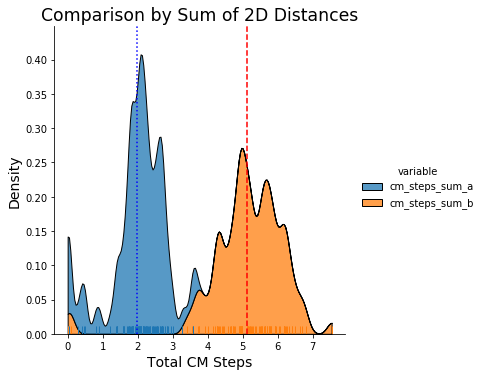

In [18]:
df_cm_sums = pd.DataFrame({"cm_steps_sum_a": all_cm_steps_sums_a, "cm_steps_sum_b": all_cm_steps_sums_b})
df_cm_sums2 = pd.melt(df_cm_sums, value_vars =['cm_steps_sum_a', 'cm_steps_sum_b']) 

ax = sns.displot(df_cm_sums2, x ="value", kind="kde", hue='variable',
                 multiple="stack", bw_adjust=0.3, cut=0.0, rug=True)

plt.axvline(x=np.mean(df_cm_sums['cm_steps_sum_a']), color='b', linestyle=':')
plt.axvline(x=np.mean(df_cm_sums['cm_steps_sum_b']), color='r', linestyle='--')
# ax.set(xlim=(-0.01, 8))

plt.title('Comparison by Sum of 2D Distances', fontsize=16)

for a in ax.axes.flat:
    a.set_title(a.get_title(), fontsize='xx-large')
    a.set_xlabel('Total CM Steps', fontsize=14)
    a.set_ylabel('Density', fontsize=14)
plt.show()